**Задача 1. Движения тела, брошенного под углом к горизонту (без и с учетом сопротивления воздуха)**

Рассмотрим физическую модель движения тела, брошенного под углом к горизонту с учетом сопротивления воздуха.  
  
Модель должна позволять вычислять положение тела в любой момент времени.  
  
Исходными данными для модели будут являться масса тела, начальные координаты, начальная скорость и угол броска.  
    
Для данной модели будем считать тело материальной точкой массой m, положение которой совпадает с центром масс тела.  
  
Движение Тела происходит в поле силы тяжести с постоянным ускорением свободного падения g.
  
  

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container {width: 100%; !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 30)

pd.set_option('display.precision',3)

In [9]:
# Ускорение свободного падения м/с^2:
g = 9.80665

# Начальная скорость м/с:
V0 = 12

# Угол броска к горизонту градусы:
alpha = np.array([15, 35, 45, 60, 70])

# Масса тела кг:
m = 3

# Коэффициент трения кг/с:
b = 0.12

# Размерность сетки:
n_grid = np.array([10, 25, 50, 1000])

Построим график движения тела без учета сопротивления воздуха:

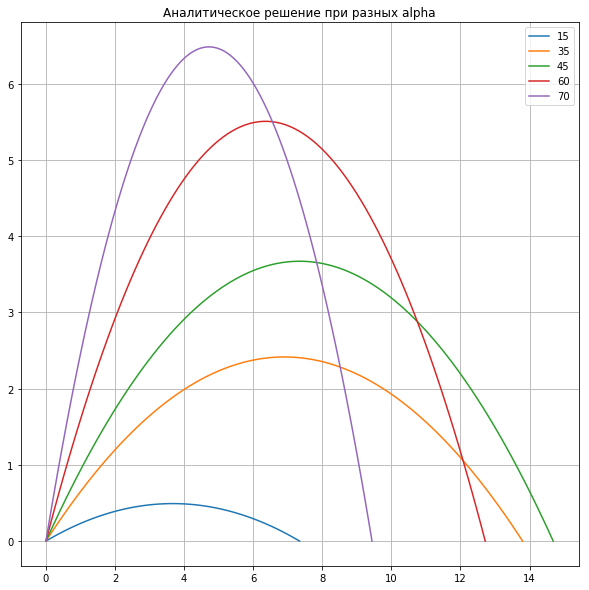

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(10, 10))
plt.title("Аналитическое решение при разных alpha")

for a in alpha:
    a_ = np.deg2rad(a)
    S = V0 ** 2 * np.sin(2*a_) /  g
    x = np.linspace(0, S, 100)
    y = x * np.tan(a_) - (x**2 * g) / (2 * V0**2 * np.cos(a_)**2)
    plt.plot(x, y)


lgnd = plt.legend(alpha)

plt.grid()

plt.show()
plt.savefig('01_daff_a.png')

  
На графике выше показана зависимость дальности полета тела от заданного угла броска к горизонту.  
  
(начальная скорость и масса тела зафиксированы)

  
Построим график движения тела с учетом сопротивления воздуха, зафиксируем Alpha=60:

In [11]:
a = 60
a_ = np.deg2rad(a)

In [12]:
# Функция расчета значений аналитически

def analitic_result(V, al, mass, b_, n_gr):
    g = 9.80665
    T = 2 * V * np.sin(al) / g
    
    time = np.linspace(0, T, n_gr)
    
    e = 1 - np.exp(-b_ / mass * time)
    
    x = (mass * V / b_) * np.cos(al) * e
    y = (mass / b_) * (g * mass / b_ +
                       V * np.sin(al)) * e - g * mass * time / b_
    return time, x, y

In [13]:
# Функция расчета значений численно

def model_result(V, al, mass, b_, n_gr):
    g = 9.80665
    T = 2 * V * np.sin(al) / g
    tau = T / (n_gr - 1)
    k = b_ / mass
    
    Vx = np.zeros((2, n_gr), dtype=np.float32)
    Vx[0, 0] = V * np.cos(al)
    for i in range(n-1):
        Vx[1, i] = Vx[0, i]*(1 - tau * k / 2)
        Vx[0, i+1] = Vx[0, i] - tau * k * Vx[1, i]

    x = np.append(0., tau * Vx[1, :-1])
    x = x.cumsum()   
    
    Vy = np.zeros((2, n_gr), dtype=np.float32)
    Vy[0, 0] = V0 * np.sin(al)
    for i in range(n-1):
        Vy[1, i] = Vy[0, i] - tau * (k * Vy[0, i] + g) / 2
        Vy[0, i+1] = Vy[0, i] - tau * (k * Vy[1, i] + g)

    y = np.append(0., tau * Vy[1, :-1])
    y = y.cumsum()
    
    return x, y

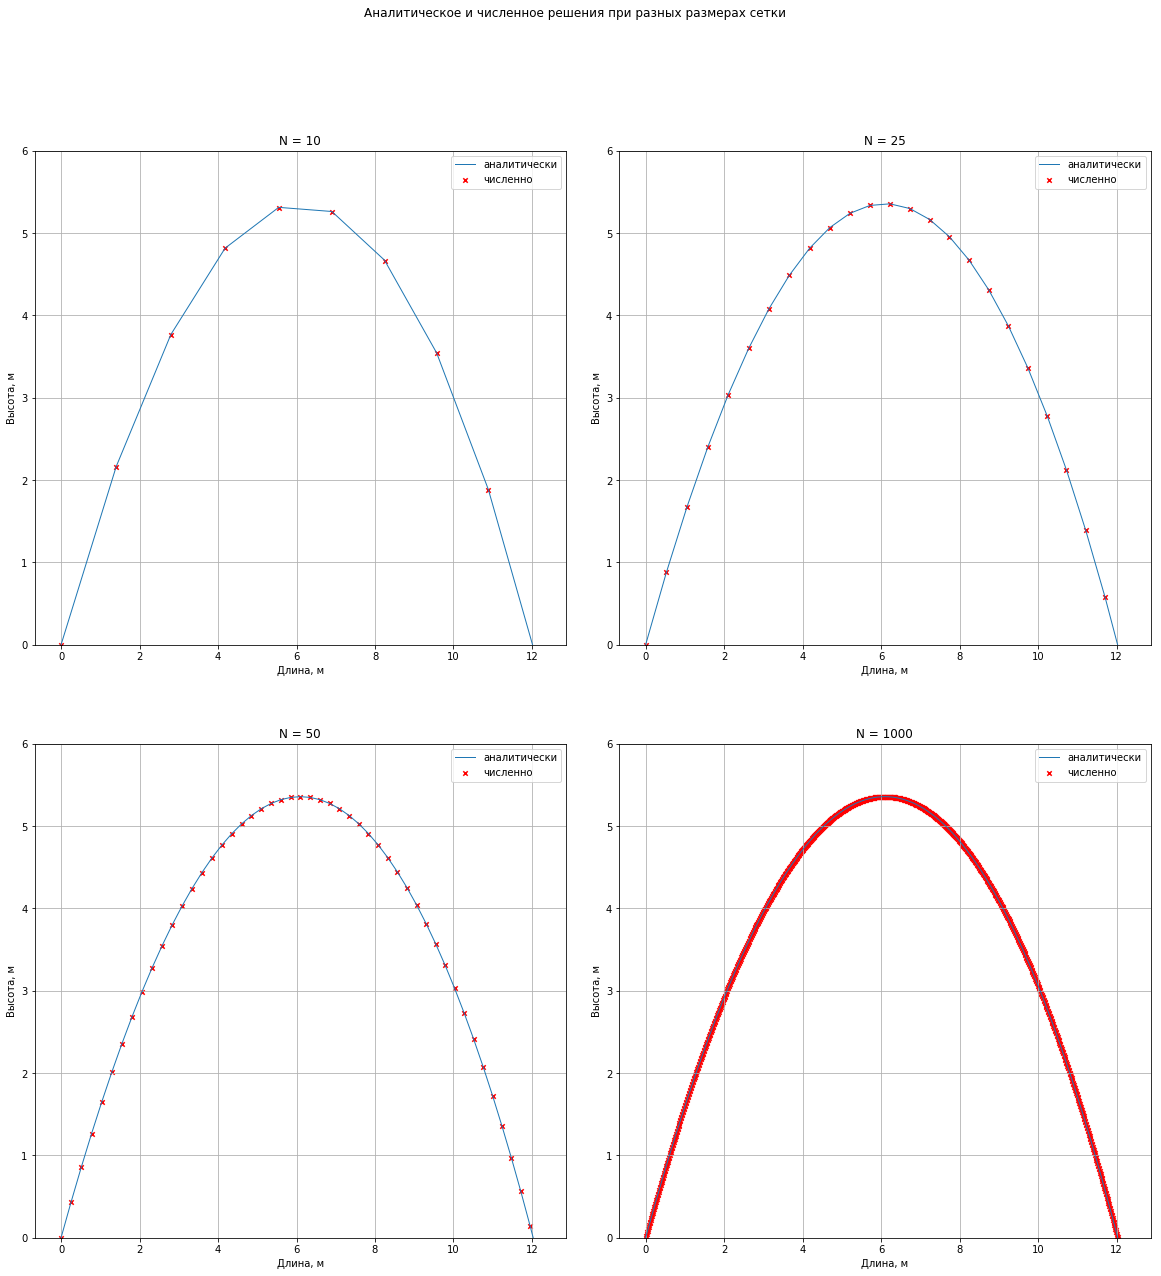

In [14]:
fig, axes = plt.subplots(2,2)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle("Аналитическое и численное решения при разных размерах сетки")

result = dict()
for j, n in enumerate(n_grid):
    ind = int(j > 1)
    axes[ind, j%2].set_title('N = {0}'.format(n))
    axes[ind, j%2].set_xlabel('Длина, м')
    axes[ind, j%2].set_ylabel('Высота, м')
    axes[ind, j%2].grid()
    
    t, x_an, y_an = analitic_result(V0,a_, m, b, n)
    axes[ind, j%2].plot(x_an, y_an, lw=1,
                        label='аналитически')
    
    x, y = model_result(V0,a_, m, b, n)
    axes[ind, j%2].set_ylim([0, int(y.max() + 1)])
    axes[ind, j%2].scatter(x, y, color='r',
                           marker='x', s=20, label='численно')
    axes[ind, j%2].legend()
    
    feat_to_df = {'t': t,
                  'x': x,
                  'y': y,
                  'delta_hight': np.abs(x - x_an),
                  'delta_lenght':  np.abs(y - y_an)}
    
    df_results = pd.DataFrame(feat_to_df)
    df_results.index = df_results.t
    df_results.drop(['t'], axis=1, inplace=True)
    result.update({n: df_results})

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()
fig.savefig('01_diff_n.png')

In [16]:
# Результаты и погрешность численных вычислений:

for r in result:
    print('Размерность сетки: N = {0}\n{1}\n...'.format(r, result[r].head()))
    
    delta_x = result[r].delta_hight.mean()
    delta_y = result[r].delta_lenght.mean()
    print('Погрешность по высоте = {:.6f}\nПогрешность по длинне = {:.10f}\n'.format(delta_x, delta_y))

Размерность сетки: N = 10
           x      y  delta_hight  delta_lenght
t                                             
0.000  0.000  0.000    0.000e+00     0.000e+00
0.235  1.406  2.164    2.079e-05     8.880e-04
0.471  2.799  3.766    4.111e-05     1.759e-03
0.706  4.179  4.812    6.106e-05     2.614e-03
0.942  5.547  5.307    8.069e-05     3.453e-03
...
Погрешность по высоте = 0.000089
Погрешность по длинне = 0.0038008305

Размерность сетки: N = 25
           x      y  delta_hight  delta_lenght
t                                             
0.000  0.000  0.000    0.000e+00     0.000e+00
0.088  0.529  0.878    1.063e-06     4.688e-05
0.177  1.056  1.676    2.134e-06     9.345e-05
0.265  1.581  2.396    3.175e-06     1.397e-04
0.353  2.105  3.036    4.241e-06     1.857e-04
...
Погрешность по высоте = 0.000012
Погрешность по длинне = 0.0005338223

Размерность сетки: N = 50
           x      y  delta_hight  delta_lenght
t                                             
0.000  0.000  0.000 